# RL w/ Verifiable Rewards Experiments
Default to left-to-right arithmetic with shared helpers in `rlvr_math.py`.

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import torch
from rlvr_math import (
    DEFAULT_MODEL_ID,
    TaskConfig,
    TrainConfig,
    measure_baseline_accuracy,
    train_grpo_integer_math,
    load_trainer_logs,
    load_mem_log,
    plot_losses,
    plot_memory,
    summarize_logs,
)

logging.basicConfig(level=logging.INFO, format="%(message)s")

USE_4BIT = True
DTYPE = torch.float32  # for compat w/ GRPO framework :/

task_cfg = TaskConfig(
    task_mode="ltr",
    ltr_min_steps=4,
    ltr_max_steps=7,
    val_range=9999,
    mul_range=50,
)

eval_seed = 123


### Baseline accuracy (matches training task)
Using left-to-right arithmetic to keep evaluation aligned with the RL task.

In [2]:
baseline = measure_baseline_accuracy(
    model_id=DEFAULT_MODEL_ID,
    task_cfg=task_cfg,
    n_eval=100,
    device="cuda",
    dtype=DTYPE,
    load_in_4bit=USE_4BIT,
    eval_seed=eval_seed,
)
baseline

`torch_dtype` is deprecated! Use `dtype` instead!
We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
{
  "model": "Qwen/Qwen3-0.6B",
  "task_mode": "ltr",
  "n": 100,
  "accuracy": 0.01,
  "samples": [
    {
      "problem": "Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-6470 - -8749 + 2424 - 7571 - 8427\nWhat is the result?",
      "gold": -11295,
      "raw": "-6470 - -8749 + 2424 - 7571 - 8427\n\nLet's evaluate the expression step by step:\n\n1. -6470 - (-8749) = 6470 + 8749 = 15219  \n2. 15219 + 2424 = 17643  \n3. 17643 - 7571 = 10072  \n4. 10072 - 8",
      "pred": 8,
      "ok": false
    },
    {
      "problem": "Evaluate this expression strictly fro

{'model': 'Qwen/Qwen3-0.6B',
 'task_mode': 'ltr',
 'n': 100,
 'accuracy': 0.01,
 'samples': [{'problem': 'Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-6470 - -8749 + 2424 - 7571 - 8427\nWhat is the result?',
   'gold': -11295,
   'raw': "-6470 - -8749 + 2424 - 7571 - 8427\n\nLet's evaluate the expression step by step:\n\n1. -6470 - (-8749) = 6470 + 8749 = 15219  \n2. 15219 + 2424 = 17643  \n3. 17643 - 7571 = 10072  \n4. 10072 - 8",
   'pred': 8,
   'ok': False},
  {'problem': 'Evaluate this expression strictly from left to right (ignore normal operator precedence):\n938 - -1966 + -4633 + -9945 + 4296 - -7129 * 26\nWhat is the result?',
   'gold': -6474,
   'raw': '-938 - -1966 + -4633 + -9945 + 4296 - -7129 * 26',
   'pred': 26,
   'ok': False},
  {'problem': 'Evaluate this expression strictly from left to right (ignore normal operator precedence):\n-6960 + -5341 + -5863 - -9304 * -13 - 4112 + 8790 + 5628\nWhat is the result?',
   'gold': 

### GRPO training
Defaults target the LTR task with concise logging and quick-run sizing.

In [3]:
cfg = TrainConfig(
    model_id=DEFAULT_MODEL_ID,
    task=task_cfg,
    train_seed=42,
    eval_seed=eval_seed,
    quick_run=True,
    run_name="grpo-math-quick",
    output_dir="qwen3-06b-grpo-math-quick",
    logging_steps=5,
    load_in_4bit=USE_4BIT,
    dtype=DTYPE,
)

trainer = train_grpo_integer_math(cfg)

Map:   0%|          | 0/1024 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

`torch_dtype` is deprecated! Use `dtype` instead!
We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
[mem] start used=3.66GiB free=28.18GiB total=31.84GiB reserved=1.85GiB
`generation_config` default values have been modified to match model-specific defaults: {'temperature': 0.6}. If this is not desired, please set these values explicitly.
/home/jan/miniconda3/envs/torch312/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.000000,0.000000
100,0.000000,0.000000
150,0.000000,0.000000
200,0.000000,0.000000
250,0.000000,0.000000
300,0.000000,0.000000
350,0.000000,0.000000
400,0.000000,0.000000


[mem][step 5] used=4.64GiB (14%) step_t=11.23s tok/s~365 seq/s~5.7 ETA~73m55s
[log][step 5] loss=0.0000 reward=0.000 ema=0.000 adv~0.000 kl=0.0000
[mem][step 10] used=4.64GiB (14%) step_t=11.18s tok/s~366 seq/s~5.7 ETA~72m39s
[log][step 10] loss=0.0000 reward=0.000 ema=0.000 adv~0.000 kl=0.0000
[mem][step 15] used=4.64GiB (14%) step_t=11.00s tok/s~372 seq/s~5.8 ETA~70m33s
[log][step 15] loss=0.0000 reward=0.000 ema=0.000 adv~0.000 kl=0.0000
[mem][step 20] used=4.64GiB (14%) step_t=11.03s tok/s~371 seq/s~5.8 ETA~69m51s
[log][step 20] loss=0.0000 reward=0.000 ema=0.000 adv~0.000 kl=0.0000
[mem][step 25] used=4.64GiB (14%) step_t=10.81s tok/s~379 seq/s~5.9 ETA~67m35s
[log][step 25] loss=0.0000 reward=0.000 ema=0.000 adv~0.000 kl=0.0000
[mem][step 30] used=4.64GiB (14%) step_t=10.89s tok/s~376 seq/s~5.9 ETA~67m7s
[log][step 30] loss=0.0000 reward=0.000 ema=0.000 adv~0.000 kl=0.0000
[mem][step 35] used=4.64GiB (14%) step_t=11.07s tok/s~370 seq/s~5.8 ETA~67m19s
[log][step 35] loss=0.0000 rew

### Training diagnostics

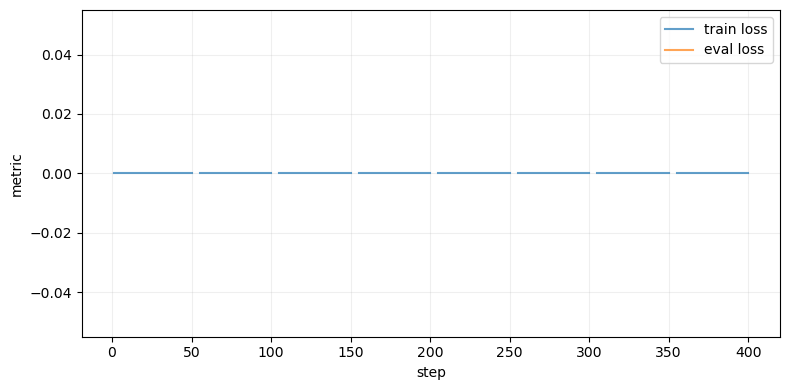

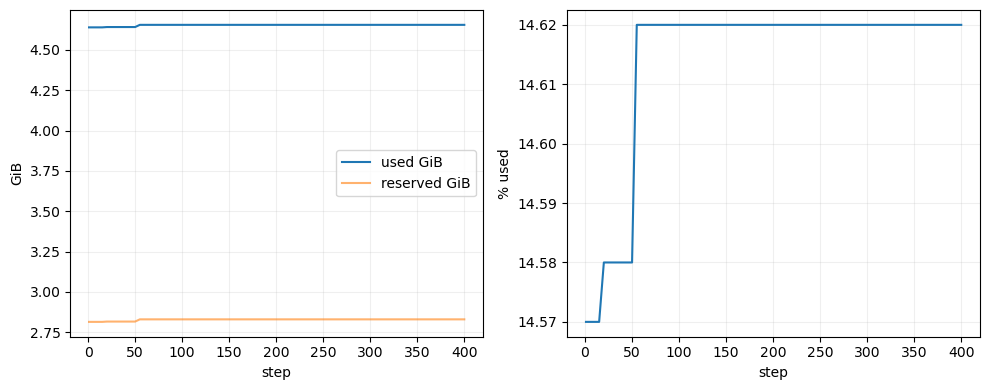

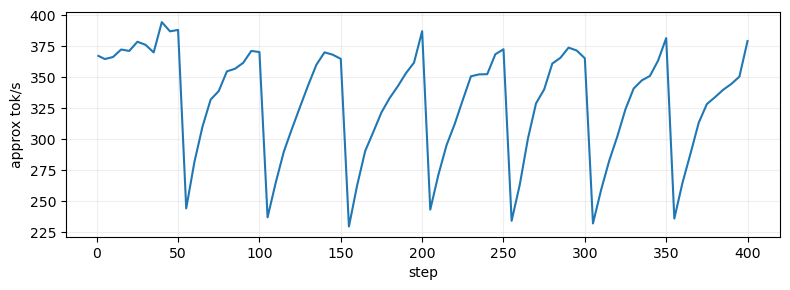

/home/jan/workspace/transformer-experiments/rlvr_math.py:808: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  out["final_train_loss"] = float(pd.to_numeric(df["loss"], errors="coerce").dropna().tail(1))
{
  "final_train_loss": 0.0,
  "best_eval_loss": 0.0,
  "peak_used_gib": 4.6558,
  "mean_tok_s": 335.48144444444443
}


{'final_train_loss': 0.0,
 'best_eval_loss': 0.0,
 'peak_used_gib': 4.6558,
 'mean_tok_s': 335.48144444444443}

In [4]:
df = load_trainer_logs(cfg.output_dir)
dfm = load_mem_log(cfg.output_dir)
plot_losses(df)
plot_memory(dfm)
summarize_logs(df, dfm)